# Evaluación 2

---



**Autor:**

**Correo Electrónico:**

**Fecha de Creación:** Junio 2025

**Versión:** 1.0  



---

## Descripción

Este notebook corresponde al desarrollo de la entrega 2 de la asignatura electiva de Machine Learning de DuocUC - Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- numpy (2.0.2)
- matplotlib (3.10.0)
- pandas (2.2.2)
- seaborn (0.13.2)
- sklearn (1.6.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Fase 0 - Cargar de los datos

In [1]:
!wget https://www.dropbox.com/s/h160fwrthtb4gte/Base_Clientes_Monopoly.csv

--2025-06-04 03:24:22--  https://www.dropbox.com/s/h160fwrthtb4gte/Base_Clientes_Monopoly.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mz5u7ddatqayntt2crleq/Base_Clientes_Monopoly.csv?rlkey=nyn3hzxxby855id3gxxlbdev6 [following]
--2025-06-04 03:24:22--  https://www.dropbox.com/scl/fi/mz5u7ddatqayntt2crleq/Base_Clientes_Monopoly.csv?rlkey=nyn3hzxxby855id3gxxlbdev6
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d24878e478599d0d2bbd524f5.dl.dropboxusercontent.com/cd/0/inline/Cq98M77ntpTBN1ltv-J7KPSG34tJLAlTHun4V5zHY73UKw-GS71N73fHrLkfjfnJnipnjFyr8OgyjaGu6yO_QpmO1-ZqPvJNbQ8ncpw1bEejkCNHiNamS_mZvR1efvuADw9jDuBzSxjeMgqrwELANR__/file# [following]
--2025-06-04 03:24:22--  https://uc8d24878e478599d0d2bbd524

In [2]:
#Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("Base_Clientes_Monopoly.csv", sep=";", decimal=",", low_memory = False)

# Fase 3 - Preparación de los datos

## Tratamiento de nulos

In [5]:
# Escriba su código acá
num_cols = ['FacCN_T12',
'Txs_T12',
'ColL1T0_T12',
'FacCCPC_T12',
'TxsCN_T12',
'Fac_T12']

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [6]:
col_clf = ['FlgActCN_T02',
'FlgActCN_T03',
'FlgActCN_T01',
'FlgActCN_T04',
'ColL1TE_T04',
'target']

df[col_clf] = imputer.fit_transform(df[col_clf])

## Transformación de variables

In [7]:
# Escriba su código acá
df_numerico = df.select_dtypes(include=['number'])

target = df_numerico['target']
features = df_numerico.drop(columns=['target'])

scaler = StandardScaler()
array_scaler = scaler.fit_transform(features)

df_scaler = pd.DataFrame(array_scaler, columns=features.columns)

df_scaler['target'] = target.reset_index(drop=True)

# Fase 4 - Modelamiento

## Modelos de regresión

### Definición de Variable objetivo

Se analizará a la variable "Fac_T12", que nos dice el monto de la factura por el cliente en la tarjeta de crédito en el mes 12. Con el fin de segmentar a los clientes como: rango alto, rango medio, rango bajo o inactivo. Esto, con la finalidad de definir estrategías de marketing personalizadas. Además de ayudar a gestionar riesgos en cuanto a créditos que se les puedan otorgar.  

In [45]:
# Escriba su código acá
y = df['Fac_T12']
data_y = pd.DataFrame(y)

### Distribución de variable objetivo

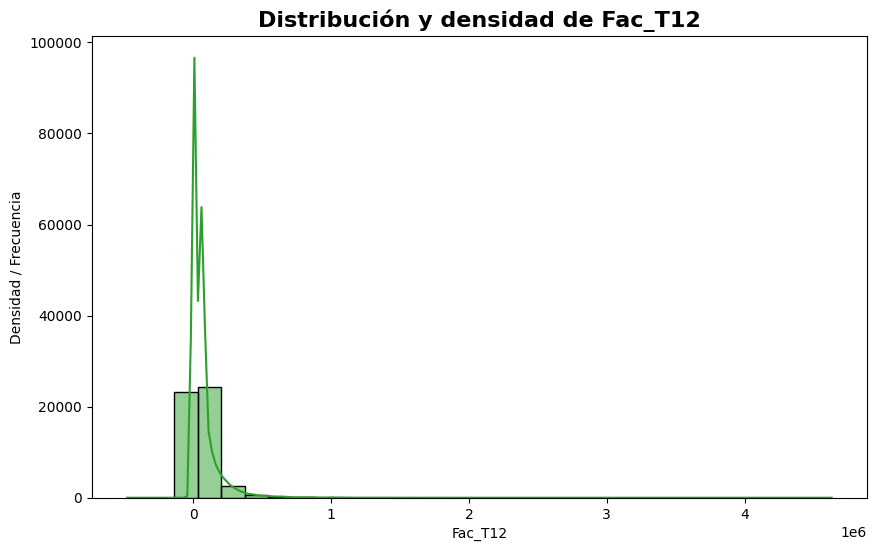

In [46]:
# Escriba su código acá
plt.figure(figsize=(10, 6))
sns.histplot(df['Fac_T12'], bins=30, kde=True, color=sns.color_palette()[2])
plt.title("Distribución y densidad de Fac_T12", fontsize=16, fontweight="bold")
plt.xlabel("Fac_T12")
plt.ylabel("Densidad / Frecuencia")
plt.show()

En el gráfico se aprecia que la mayoría de personas están en el rango de 0 a 1.000.000 de pesos, donde se aprecia también que hay quienes están debajo del 0, lo que se podría deber a un error de tipeo, o algún otro factor.

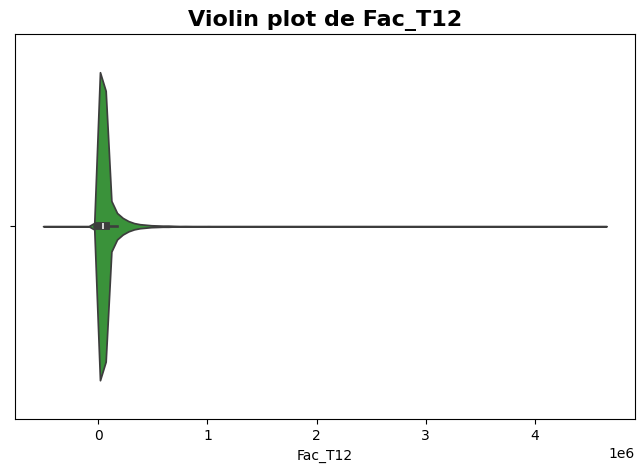

In [47]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['Fac_T12'], color=sns.color_palette()[2])
plt.title("Violin plot de Fac_T12", fontsize=16, fontweight="bold")
plt.xlabel("Fac_T12")
plt.show()

Con este gráfico reforzamos la idea anterior.

### Selección de variables independientes

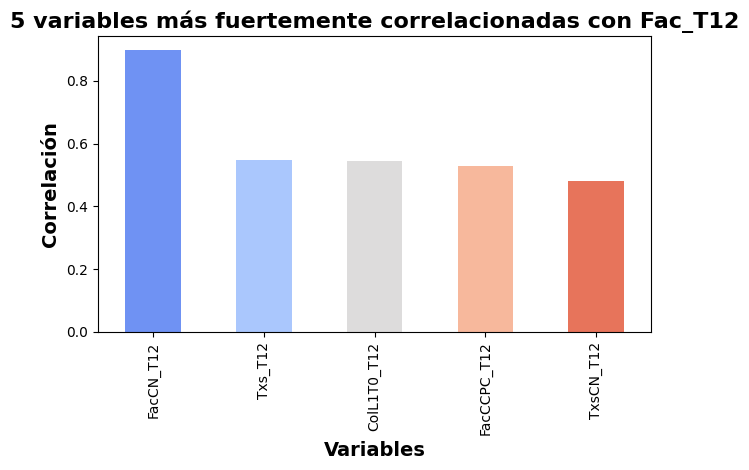

In [48]:
data_copia = df_scaler.copy()
data_copia['Fac_T12'] = y
corrs = data_copia.corr(numeric_only=True)['Fac_T12'].drop('Fac_T12').sort_values(ascending=False)

top_abs_corrs = corrs.abs().sort_values(ascending=False).head(5)

top_corrs_signed = corrs.loc[top_abs_corrs.index]

ax = top_corrs_signed.plot(kind='bar', color=sns.color_palette("coolwarm", 5))
ax.set_title('5 variables más fuertemente correlacionadas con Fac_T12', fontsize=16, fontweight='bold')
ax.set_ylabel('Correlación', fontsize=14, fontweight="bold")
ax.set_xlabel('Variables', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Este gráfico nos ayuda a seleccionar las variables candidatas a predecir nuestra variable objetivo, de las cuales se escogen las más "fuertes", y nos muestra que son: FacCN_T12',
'Txs_T12',
'ColL1T0_T12',
'FacCCPC_T12',
'TxsCN_T12'. Por lo cual se prodecerá a trabajar con ellas.

In [49]:
#Se seleccionan las variables de "num_cols", "quitando Fac_T12", debido a que es nuestra variable objetivo
X = df_scaler[[col for col in num_cols if col != 'Fac_T12']]
data_x = pd.DataFrame(X)

### Separación datos de entrenamiento y test

In [50]:
# Escriba su código acá
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=29)

### Algoritmo 1 - `Regresion Polinomial`

#### Creación del modelo

Para el algoritmo de Regresión Polinomial, se usa un grado polinomial de 3, debido a que no requiere de un analisis muy complejo, y no queremos generar un sobreajuste.
También se usa el 30% de datos para pruebas, para los demás usarlos de test.

In [51]:
# Escriba su código acá
grado_polinomio = 3
N = 17000
polyfeats = PolynomialFeatures(degree = grado_polinomio, include_bias = True)
variable = 'FacCN_T12'
X = np.array(data_x[variable][:N]).reshape(-1,1)
X_poly = polyfeats.fit_transform(X)

#### Entrenamiento del modelo

In [52]:
# Escriba su código acá
reg_poly = LinearRegression(fit_intercept = False)
reg_poly.fit(X_poly, data_y[:N])

LinearRegression(fit_intercept=False)

#### Evaluación del modelo

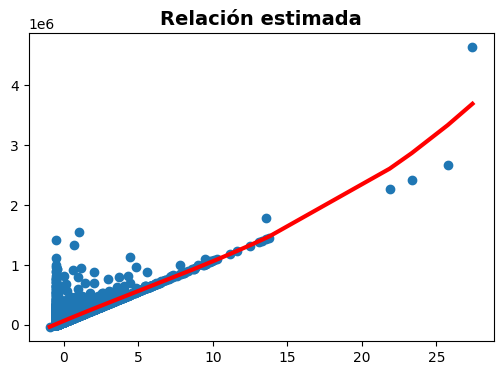

In [53]:
# Escriba su código acá
l_ordenada = list(data_x[variable][:N])
l_ordenada.sort()

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
plt.scatter(X, data_y[:N])

y_estimado = np.polyval(np.flip(reg_poly.coef_[0]), l_ordenada)

ax.plot(l_ordenada, y_estimado, color = 'red', linewidth = 3)

plt.title("Relación estimada", fontsize=14, fontweight="bold")
plt.show()

#### Cálculo e interpretación de métricas

##### R2

In [54]:
# Escriba su código acá
print('Calidad de ajuste R^2 = {:.3f}'.format(reg_poly.score(X_poly, data_y[:N])))

Calidad de ajuste R^2 = 0.820


Un 82% nos sugiere una relación fuerte entre nuestra variable independiente y la dependiente.

##### MAE

In [55]:
# Escriba su código acá
print('Mean absolute error: %.2f'
      % mean_absolute_error(data_y[:N], y_estimado))

Mean absolute error: 89763.01


Un mean absolute error de 89763.01, quiere decir que el error promedio es de 89.763 pesos.

### Algoritmo 2 - `DecisionTreeRegressor`

#### Creación del modelo

Se crea un árbol de profundidad 5, debido a que es más fácil de interpretar. Además de controlar el sobreajuste.

In [56]:
# Escriba su código acá
reg_tree = DecisionTreeRegressor(max_depth=5)

#### Entrenamiento del modelo

Profundidad del árbol: 5


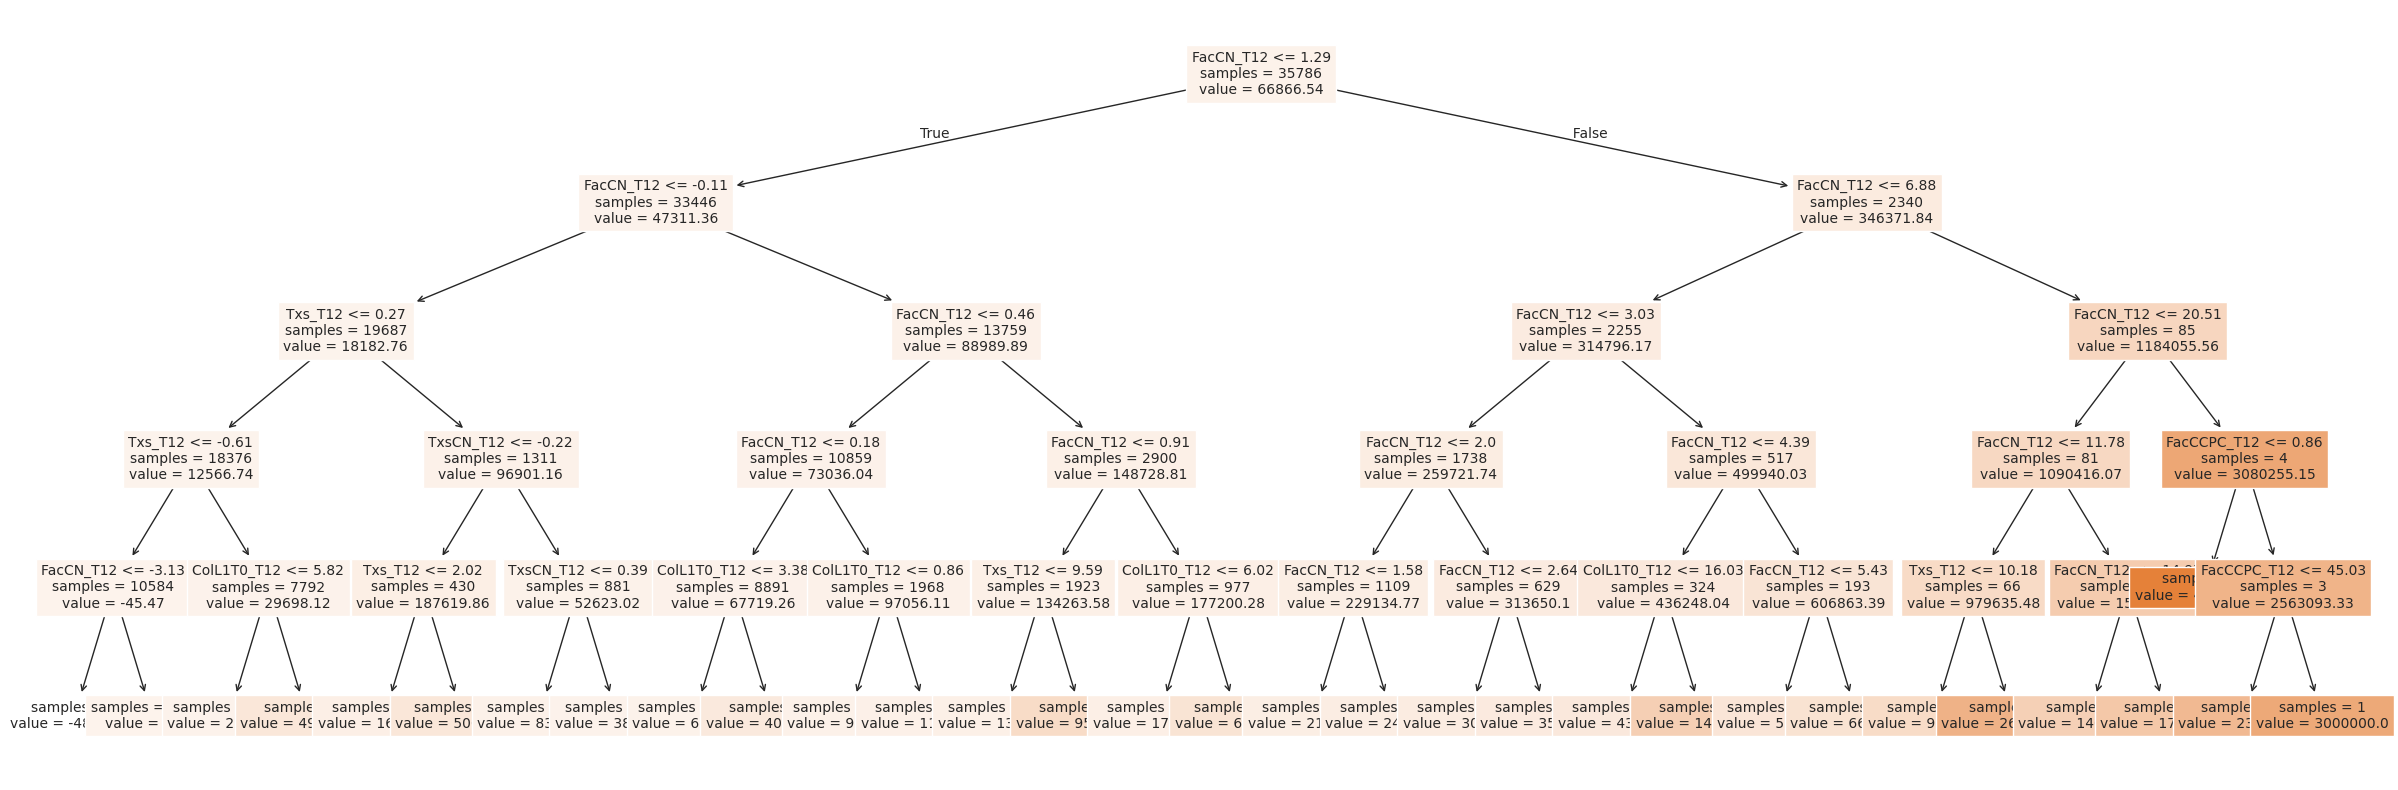

In [102]:
# Escriba su código acá
reg_tree.fit(X_train, y_train)
y_predicted = reg_tree.predict(X_test)

# Visualización
fig, ax = plt.subplots(figsize=(30, 10))
print('Profundidad del árbol:', reg_tree.get_depth())

plot = plot_tree(decision_tree = reg_tree,
      feature_names = data_x.columns,
      filled = True,
      impurity = False,
      fontsize = 10,
      precision = 2,
      ax = ax)

El árbol nos muestra qué variables son más importantes para la predición, en este caso, como se puede apreciar, las variables FacCN_T12 y FacCCPC_T12, son con diferencia, las más relevantes.

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### R2

In [74]:
# Escriba su código acá
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_predicted))

Coefficient of determination: 0.81


Un 81% de R2, nos indica una fuerte relación entre las variables independientes y la dependiente.

In [75]:
y_predicted_train = reg_tree.predict(X_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_predicted_train))

Coefficient of determination: 0.87


Aquí apreciamos como le fue con el set de entrenamiento.

##### MAE

In [59]:
# Escriba su código acá
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_predicted))

Mean absolute error: 13041.49


Aquí el MAE nos muestra que se equivoca en promedio 13.041 pesos.

### Comparación de los modelos

En ambos modelos tenemos un R2 alto de un 82 y un 81% respectivamente. Por lo que nos fijaremos en el MAE en este caso, y con diferencia, el que tiene un error absoluto menor es el algortimo DecisionTreeRegressor con casi 77.000 pesos de diferencia.

## Modelo de clasificación

### Distribución de variable objetivo

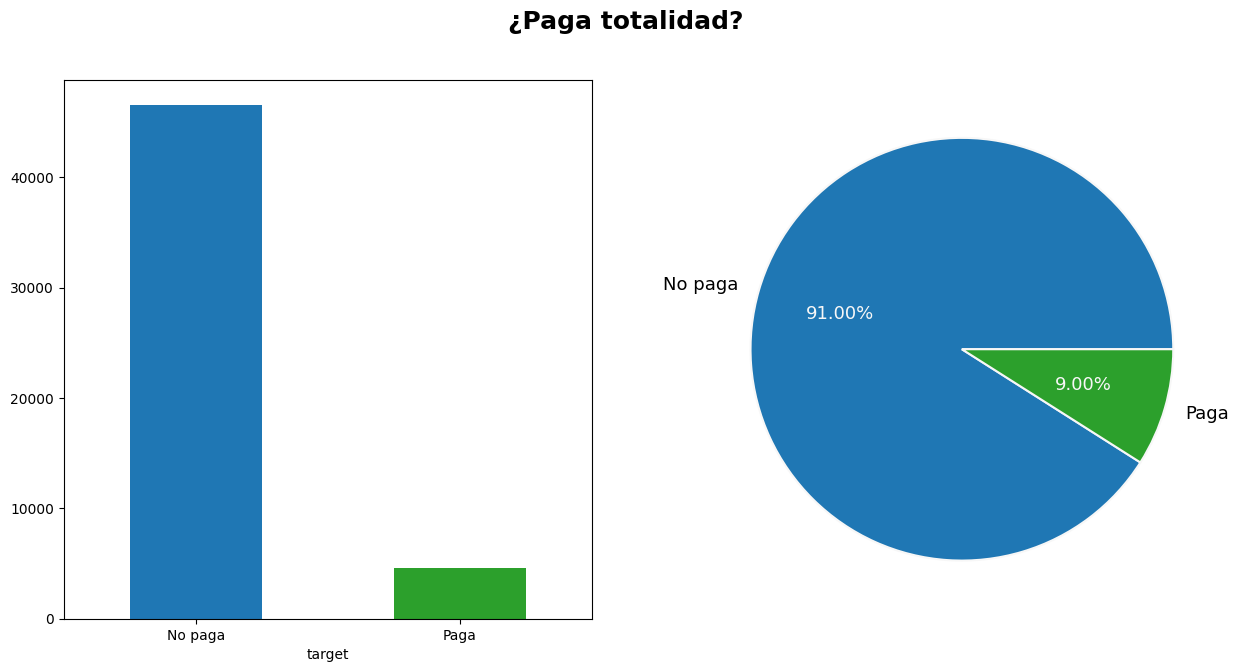

In [60]:
# Escriba su código acá
y_clf = df_scaler["target"]

f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("¿Paga totalidad?", fontsize = 18., fontweight="bold")
_ = df_scaler.target.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["No paga", "Paga"])
_ = df_scaler.target.value_counts().plot.pie(labels = ("No paga", "Paga"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

Aquí se aprecia que los que pagan completamente la tarjeta, son muy inferiores a los que no pagan. Debido a esto, la máquina tenderá a predecir que los clientes no pagan en su totalidad su tarjeta, lo que producirá un sesgo.

### Selección de variables independientes

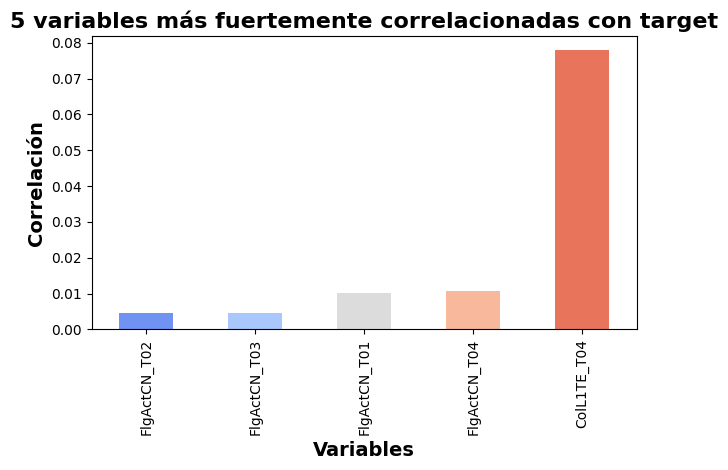

In [61]:
# Escriba su código acá
corrs_clf = data_copia.corr(numeric_only=True)['target'].drop('target').sort_values(ascending=False)

top_abs_corrs_clf = corrs_clf.abs().sort_values(ascending=False).head(5)

top_corrs_signed_clf = corrs.loc[top_abs_corrs_clf.index]

ax = top_corrs_signed_clf.plot(kind='bar', color=sns.color_palette("coolwarm", 5))
ax.set_title('5 variables más fuertemente correlacionadas con target', fontsize=16, fontweight='bold')
ax.set_ylabel('Correlación', fontsize=14, fontweight="bold")
ax.set_xlabel('Variables', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

En este gráfico analizamos las variables con mejor correlación con "target", nuestra variable objetivo. Se aprecia que son: 'FlgActCN_T02',
'FlgActCN_T03',
'FlgActCN_T01',
'FlgActCN_T04'y
'ColL1TE_T04'.

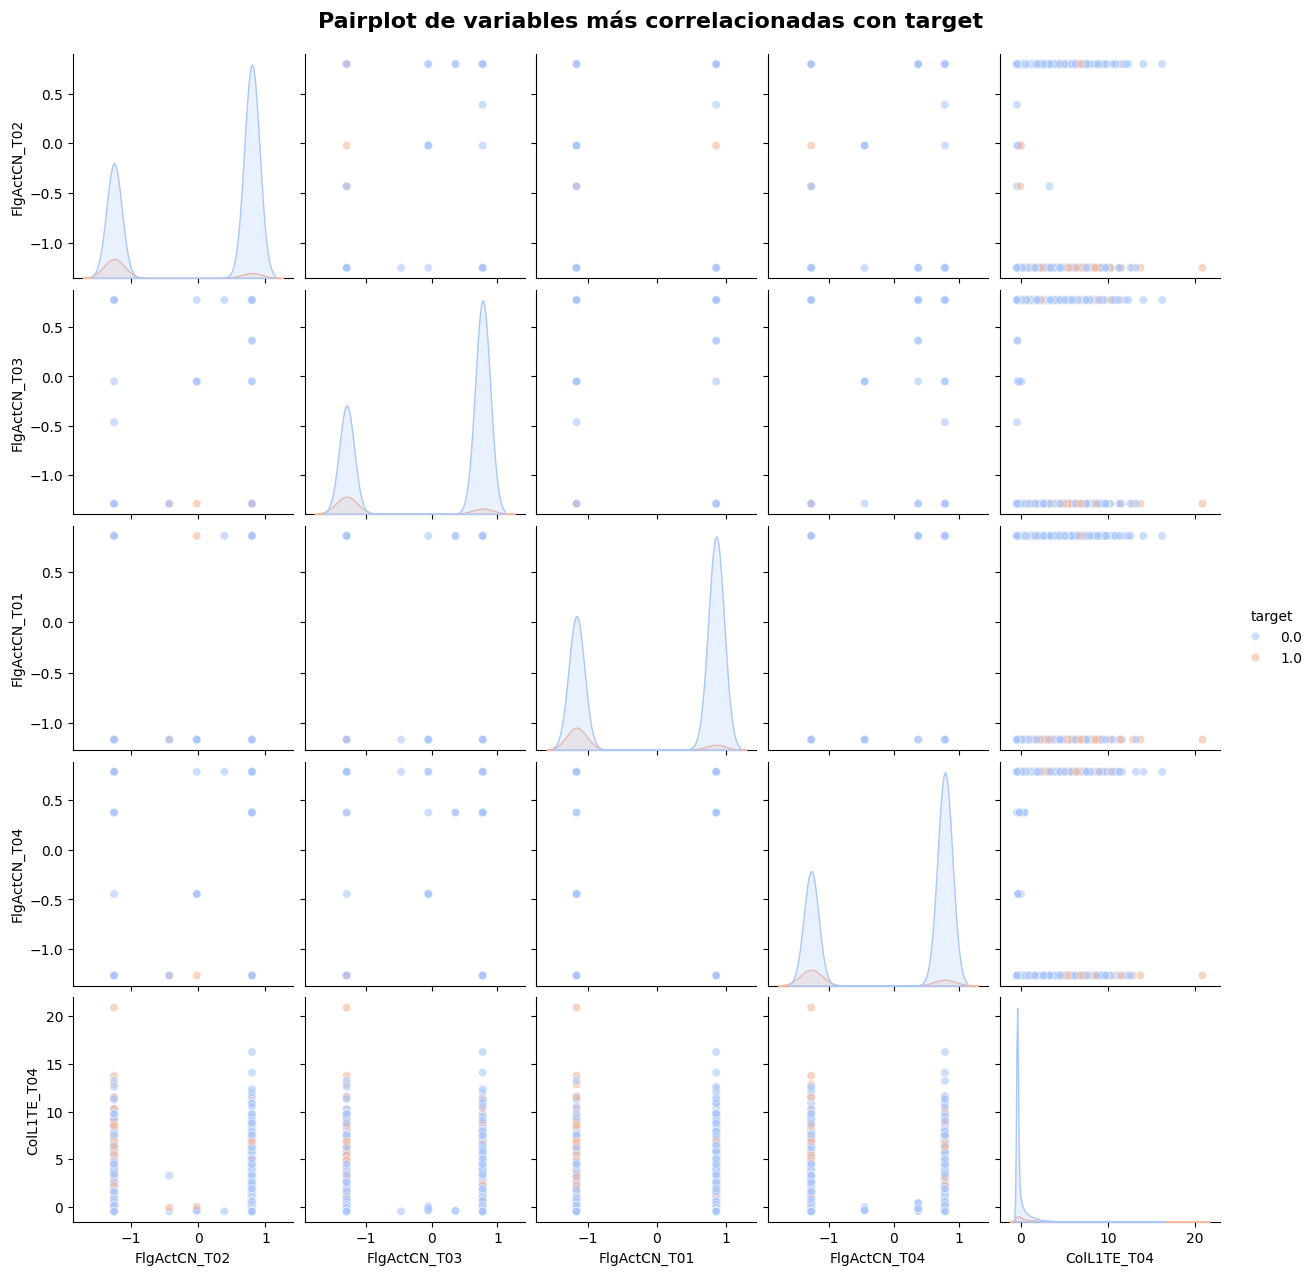

In [62]:
# Escriba su código acá
top_vars = top_corrs_signed_clf.index.tolist()
top_vars.append('target')

sns.pairplot(data=data_copia[top_vars], hue='target', palette="coolwarm", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot de variables más correlacionadas con target", fontsize=16, fontweight="bold", y=1.02)
plt.show()

Estos gráficos nos muestran las variables que se correlacionan con target y así detectar si tienen un buen poder predictivo.

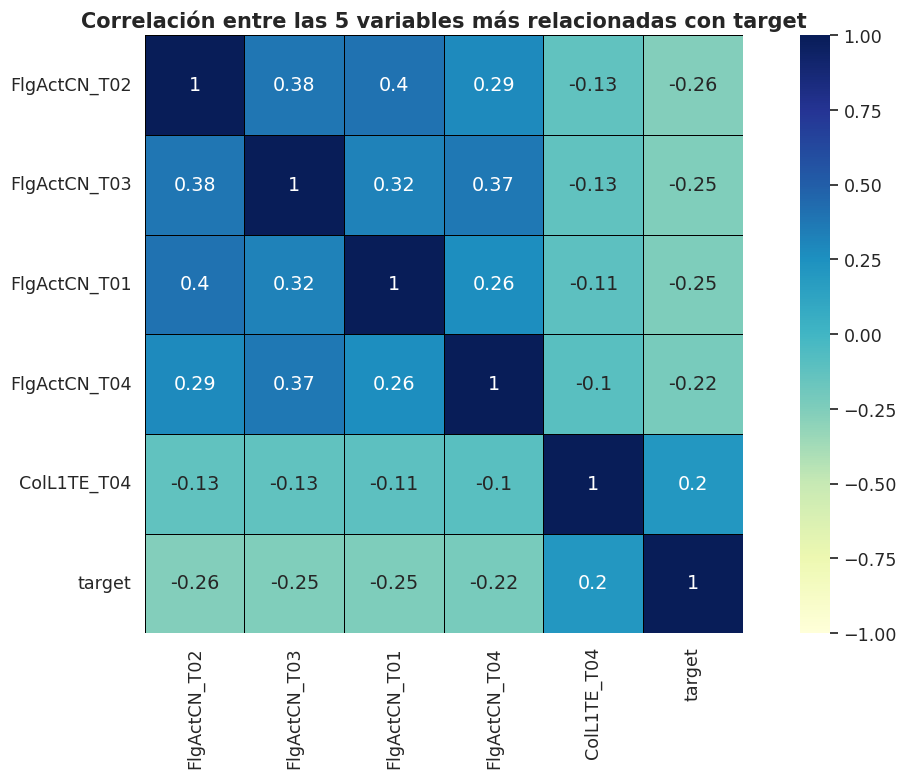

In [63]:
corr_matrix = data_copia[top_vars].corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',
            linewidths=0.5, linecolor='black', square=True, vmin=-1, vmax=1, center=0)

plt.title('Correlación entre las 5 variables más relacionadas con target', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Aquí vemos un mapa de calor, donde nos indica correlaciones tanto positivas como negativas, por ejemplo: ColL1TE_T04 tiene una correlación positiva de 0.2 con target, mientras que FlgActCN_T03 tiene una correlación negativa de -0.25.

In [64]:
X_clf = df_scaler[[col for col in col_clf if col != 'target']]
data_x_clf = pd.DataFrame(X_clf)

### Separación datos entrenamiento y test

In [65]:
# Escriba su código acá
A_train, A_test, b_train, b_test = train_test_split(data_x_clf, y_clf, test_size=0.2, random_state = 29, stratify=y_clf)

### Algoritmo 1 - DecisionTreeClassifier

#### Creación del modelo

Se usará tanto Gini como Entropy, para realizar una eventual comparación.

In [67]:
# Escriba su código acá
clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=10,
    class_weight='balanced',  # para balancear el sesgo de los datos
    random_state=29
)

clf_entropy = DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 3,
    min_samples_leaf = 20,
    class_weight='balanced',
    random_state = 29)

#### Entrenamiento del modelo

In [68]:
# Escriba su código acá
clf_gini.fit(A_train, b_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, random_state=29)

In [69]:
clf_entropy.fit(A_train, b_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=20, random_state=29)

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### Matriz de confusión

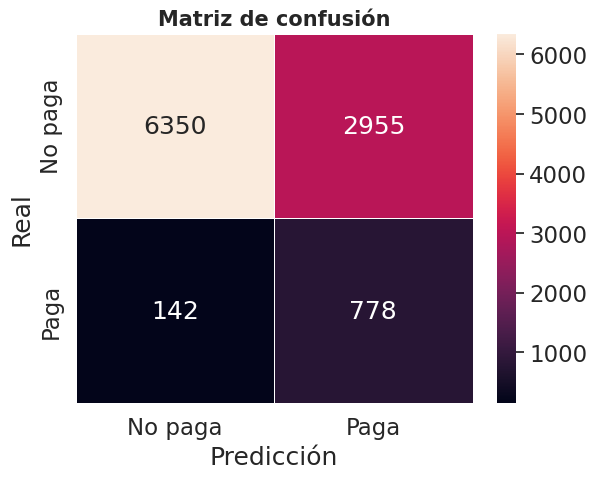



Accuracy  70.81662591687041


In [70]:
# Escriba su código acá
# Gráfica de la matriz de confusión
b_pred_entropy = clf_entropy.predict(A_test)

clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_pred_entropy)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

El gráfico de confusión con entropy predijo 6350 verdaderos positivos, 142 falsos negativos, 2955 falsos positivos, y finalmente, 778 verdaderos negativos.

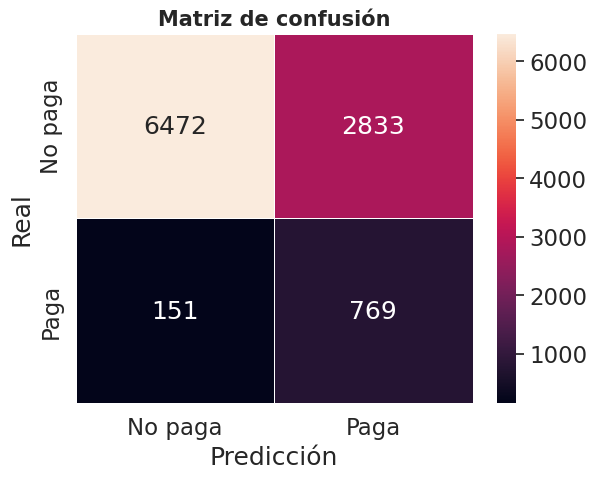



Accuracy  70.81662591687041


In [72]:
y_pred_gini = clf_gini.predict(A_test)

clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, y_pred_gini)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

Mientras que con Gini predijo 6472 verdaderos positivos, 151 falsos negativos, 2833 falsos positivos, y finalmente, 769 verdaderos negativos.

##### Accuracy

In [76]:
# Escriba su código acá
print ("Accuracy : {}".format(accuracy_score(b_test,y_pred_gini)*100))
print ("Reporte\n",  classification_report(b_test, y_pred_gini, target_names=['No paga completamenete', 'Paga completamenete']))

Accuracy : 70.81662591687041
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.70      0.81      9305
   Paga completamenete       0.21      0.84      0.34       920

              accuracy                           0.71     10225
             macro avg       0.60      0.77      0.58     10225
          weighted avg       0.91      0.71      0.77     10225



Aquí apreciamos claramente el sesgo, dado que, mientras la predicción en no paga completamente (que es el mayor conjunto de datos), tiene una precisión del 98%, y con la otra alternativa, tenemos solo un 21%.

In [77]:
print ("Accuracy : {}".format(accuracy_score(b_test,b_pred_entropy)*100))
print ("Reporte\n",  classification_report(b_test, b_pred_entropy,
                                           target_names=['No paga', 'Paga']))

Accuracy : 69.71149144254278
Reporte
               precision    recall  f1-score   support

     No paga       0.98      0.68      0.80      9305
        Paga       0.21      0.85      0.33       920

    accuracy                           0.70     10225
   macro avg       0.59      0.76      0.57     10225
weighted avg       0.91      0.70      0.76     10225



Con entropia tenemos prácticamente, los mismos resultados.

In [78]:
y_pred_gini_train = clf_gini.predict(A_train)
b_pred_entropy_train = clf_entropy.predict(A_train)

print ("Accuracy : {}".format(accuracy_score(b_train,y_pred_gini_train)*100))
print ("Reporte\n",  classification_report(b_train, y_pred_gini_train, target_names=['No paga completamenete', 'Paga completamenete']))

print("-------------------------------------------------")

print ("Accuracy : {}".format(accuracy_score(b_train,b_pred_entropy_train)*100))
print ("Reporte\n",  classification_report(b_train, b_pred_entropy_train, target_names=['No paga completamenete', 'Paga completamenete']))

Accuracy : 71.55431673146043
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.70      0.82     37219
   Paga completamenete       0.22      0.83      0.34      3680

              accuracy                           0.72     40899
             macro avg       0.60      0.77      0.58     40899
          weighted avg       0.91      0.72      0.78     40899

-------------------------------------------------
Accuracy : 70.57874275654662
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.69      0.81     37219
   Paga completamenete       0.21      0.84      0.34      3680

              accuracy                           0.71     40899
             macro avg       0.59      0.77      0.57     40899
          weighted avg       0.91      0.71      0.77     40899



Si comprobamos con los datos de entrenamiento, tenemos practicamente los mismos resultados. Lo que quiere decir que el modelo está generalizando correctamente.

#### Aplicación de `CrossValidation`

In [79]:
# Escriba su código acá
scores = cross_val_score(clf_entropy, A_train, b_train, cv=5)
print(scores)
print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.71198044 0.69718826 0.71882641 0.70085575 0.70204181]
El promedio es            : 0.71
La desviacion estandar es : 0.01


Aplicando CrossValidation, nos damos cuenta que nos confirma nuestro accuracy del 71% (en entropia), y que, además, tenemos una desviación estandar del 1%, por lo que podemos decir que el modelo es estable.

In [82]:
cv_results = cross_validate(clf_entropy, A_train, b_train, cv=5)
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

#### Análisis de métricas usando `CrossValidation`

In [81]:
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[0.03102326 0.02970052 0.02970862 0.02976108 0.03096747]
---------------
[0.0027566  0.0039432  0.00286603 0.0028286  0.00315785]
---------------
[0.71198044 0.69718826 0.71882641 0.70085575 0.70204181]


### Algoritmo 2 - SVM

#### Creación del modelo

In [83]:
# Escriba su código acá
#Este código es para ver cual kernel nos conviene
"""
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
  svc = SVC(kernel=kernel)
  scores = cross_val_score(svc, data_x_clf, y_clf, cv=5)
  print(f"Kernel: {kernel}, Accuracy: {scores.mean():.4f}")
"""

model = SVC(kernel='rbf')

#### Entrenamiento del modelo

In [84]:
# Escriba su código acá
model.fit(A_train, b_train)
b_predicted = model.predict(A_test)

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### Matriz de confusión

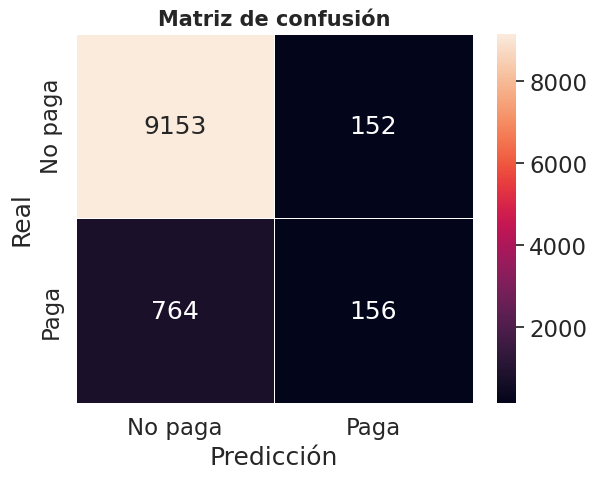



Accuracy  70.81662591687041


In [86]:
# Escriba su código acá
clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_predicted)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

El modelo SVM predijo 9153 verdaderos positivos, 764 falsos negativos, 152 falsos positivos, y finalmente, 156 verdaderos negativos.

##### Accuracy

In [87]:
# Escriba su código acá
print(classification_report(b_test, b_predicted))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      9305
         1.0       0.51      0.17      0.25       920

    accuracy                           0.91     10225
   macro avg       0.71      0.58      0.60     10225
weighted avg       0.89      0.91      0.89     10225



Tenemos un accuracy  del 91%. Donde tenemos que los que pagan completamente tienen un 51% de aciertos por parte de la máquina.

In [88]:
b_predicted_train = model.predict(A_train)
print(classification_report(b_train, b_predicted_train))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     37219
         1.0       0.53      0.15      0.23      3680

    accuracy                           0.91     40899
   macro avg       0.73      0.57      0.59     40899
weighted avg       0.89      0.91      0.89     40899



Comparandolo con los datos de entrenamiento son casi identicos, por lo que podemos decir que está haciendo un buen trabajo de generalización.

#### Aplicación de `CrossValidation`

In [89]:
# Escriba su código acá
scores = cross_val_score(model, A_train, b_train, cv=5)
print(scores)

print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.91100244 0.90929095 0.91149144 0.90977995 0.91294779]
El promedio es            : 0.91
La desviacion estandar es : 0.00


Aquí corroboramos un accuracy similar, además nos enseña una desviación estandar de 0, lo que nos indica que no hay variaciones en el modelo.

In [90]:
cv_results = cross_validate(model, A_train, b_train, cv=5)
cv_results.keys()

cv_results['fit_time']

array([14.95879555, 16.05129814, 14.1989522 , 15.85449815, 12.60296965])

#### Análisis de métricas usando `CrossValidation`

In [91]:
# Escriba su código acá
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[14.95879555 16.05129814 14.1989522  15.85449815 12.60296965]
---------------
[2.68614936 2.87928677 2.60265684 3.05906725 3.61290741]
---------------
[0.91100244 0.90929095 0.91149144 0.90977995 0.91294779]


### Algoritmo 3 - KNN

#### Creación del modelo

In [92]:
# Escriba su código acá
modelo = KNeighborsClassifier()

#### Entrenamiento del modelo

In [94]:
# Escriba su código acá
modelo.fit(A_train, b_train)

KNeighborsClassifier()

#### Evaluación del modelo

In [95]:
# Escriba su código acá
b_predi = modelo.predict(A_test)

#### Cálculo e interpretación de métricas

##### Matriz de confusión

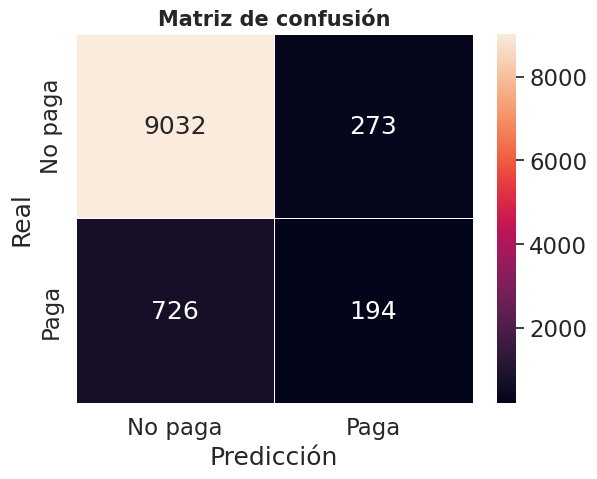



Accuracy  70.81662591687041


In [96]:
# Escriba su código acá
clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_predi)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

El modelo KNN predijo 9032 verdaderos positivos, 726 falsos negativos, 273 falsos positivos, y finalmente, 194 verdaderos negativos.

##### Accuracy

In [97]:
# Escriba su código acá
print(classification_report(b_test, b_predi, target_names = ['No paga', 'Paga']))

              precision    recall  f1-score   support

     No paga       0.93      0.97      0.95      9305
        Paga       0.42      0.21      0.28       920

    accuracy                           0.90     10225
   macro avg       0.67      0.59      0.61     10225
weighted avg       0.88      0.90      0.89     10225



Aquí apreciamos que el modelo tiene un 90% de accuracy. Además, se nota el sesgo en la opción de paga completamente, debido al amplio menor % en comparación a "No paga".

#### Aplicación de `CrossValidation`

In [98]:
# Escriba su código acá
scores = cross_val_score(modelo, A_train, b_train, cv=5)
print(scores)

print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.90268949 0.90183374 0.90354523 0.90745721 0.90451155]
El promedio es            : 0.90
La desviacion estandar es : 0.00


Además de comprobar la accuracy, también apreciamos que tiene una desviación estandar de 0, lo que nos indica que el modelo no tiene varianzas.

In [99]:
cv_results = cross_validate(modelo, A_train, b_train, cv=5)
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

#### Análisis de métricas usando `CrossValidation`

In [100]:
# Escriba su código acá
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[0.03141809 0.04515314 0.03393841 0.03281045 0.05000639]
---------------
[0.67421412 0.79946899 0.68263268 0.79682398 0.99645162]
---------------
[0.90268949 0.90183374 0.90354523 0.90745721 0.90451155]


### Comparación de los modelos

In [101]:
# Escriba su código acá
scoring = ['accuracy', 'precision', 'recall', 'f1']

modelos = {
    "Árbol Gini": clf_gini,
    "Árbol Entropía": clf_entropy,
    "SVM": model,
    "KNN": modelo  # Suponiendo que ya lo creaste
}

for nombre, modelo in modelos.items():
    resultados = cross_validate(modelo, A_train, b_train, cv=5, scoring=scoring)
    print(f"\nModelo: {nombre}")
    for metrica in scoring:
        media = resultados[f'test_{metrica}'].mean()
        std = resultados[f'test_{metrica}'].std()
        print(f"{metrica:<10} : {media:.3f} ± {std:.3f}")


Modelo: Árbol Gini
accuracy   : 0.714 ± 0.005
precision  : 0.215 ± 0.004
recall     : 0.825 ± 0.015
f1         : 0.342 ± 0.005

Modelo: Árbol Entropía
accuracy   : 0.706 ± 0.008
precision  : 0.211 ± 0.005
recall     : 0.829 ± 0.016
f1         : 0.337 ± 0.007

Modelo: SVM
accuracy   : 0.911 ± 0.001
precision  : 0.517 ± 0.026
recall     : 0.139 ± 0.032
f1         : 0.217 ± 0.043

Modelo: KNN
accuracy   : 0.904 ± 0.002
precision  : 0.431 ± 0.021
recall     : 0.209 ± 0.010
f1         : 0.281 ± 0.013


**Los modelos de árbol Gini y Entropía**
*   tienen una accuracy similar, lo cual es bueno, sin embargo, tienen una
presición muy baja, de alrededor del .21. Estos modelos se equivocan mucho con los falsos positivos.

**Modelo SVM**


*   Tiene la mayor presición y la mayor accuracy, lo que quiere decir que el modelo acierta mucho. El problema es el recall, que es muy bajo, debido a esto se equivoca en los casos verdaderos. El f1 es el más bajo, lo que quiere decir que no tiene un buen equilibrio en cuanto a presición y sensibilidad.

**Modelo KNN**



*   Tiene un accuracy alto. Con respecto al modelo SVM tiene un mejor recall y f1, aunque sigue siendo inferior a los árboles.



---


En el caso de gestionar riesgos, lo mejor es usar un modelo con un recall alto, para evitar fraudes, por ejemplo, los modelos de los árboles.

En el caso de usar la predicción como estrategia de marketing, lo mejor es buscar más presición, como el modelo SVM.



